# Diffusion
Based on the previous fourth tutorial for calculating bulk properties for unaries with the LAMMPS molecular dynamics simulation code, this tutorial covers the diffusion of hydrogen in bulk structures. Hydrogen diffusion is essential to understand the effects of hydrogen embrittlement highlighting the relevance of these simulation for engineering applications. 

In analogy to the previous exercies both codes are available as open-source software for the Linux operation system and can be installed from the `conda` package manager. See tutorial four for a detailed explanation of the installation. 

In addition, to the `Project` object from `pyiron_atomistics` also the numerical library `numpy` and the visualization library `matplotlib` are imported. The `Project` object behaves like a folder on the file system and adds the capability to create other `pyiron` objects like atomistic structures and simulation jobs. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyiron_atomistics import Project

/Users/janssen/mambaforge/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


A new `Project` object is created named `diffusion` to separate the calculation from the current tutorial and the previous. Any remaining calculation in the `diffusion` folder are removed using the `remove_jobs()` function, to provide a fresh start for every execution of the notebook.

In [2]:
pr = Project("diffusion")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/1 [00:00<?, ?it/s]

## Structure with Hydrogen Interstitials
As a first step a cubic Aluminium bulk structure is created using the `pr.create.structure.ase.bulk()` function of the project object. 

In [3]:
Al_struct = pr.create.structure.ase.bulk("Al", cubic=True)

As a second step we create an identical copy of the Aluminium structure, by copying it. We then replace the Aluminium atoms in the structure with Hydrogen. Finally, as a third step we shift the positions of the Hydrogen atoms by half a lattice constant. 

In [4]:
H_int = Al_struct.copy()
H_int[:] = "H"
H_int.positions += 0.5 * H_int.cell @ (1, 1, 1)

We then repeat both structures, twice in x and y direction and four times in the z direction this gives us an elongated sample. We are going to measure the diffusion along this elongated direction. 

In [5]:
Al_struct.set_repeat([2, 2, 4])
H_int.set_repeat([2, 2, 4])

/var/folders/9p/rztyv06d0xv4h26cyv8nrw3m0000gq/T/ipykernel_5976/3410837431.py:1: DeprecationWarning: pyiron_atomistics.atomistics.structure.atoms.set_repeat is deprecated: Use Atoms.repeat.
  Al_struct.set_repeat([2, 2, 4])
/var/folders/9p/rztyv06d0xv4h26cyv8nrw3m0000gq/T/ipykernel_5976/3410837431.py:2: DeprecationWarning: pyiron_atomistics.atomistics.structure.atoms.set_repeat is deprecated: Use Atoms.repeat.
  H_int.set_repeat([2, 2, 4])


To reach a realistic hydrogen concentration, we select ten of the Hydrogen atoms from the Hydrogen structure using the `np.random.shuffle()` function from the [numpy](http://numpy.org) package. 

In [6]:
rand_int = np.arange(0, len(H_int))
np.random.shuffle(rand_int)
H_int = H_int[rand_int[:10]]

Finally, both structures are combined by just adding them together. This is part of the pyiron design principles, using Python standard commands extended for the application on atomistic structures and simulation codes. The resulting structure is then visualized using `NGLview`, by increasing the `particle_size` to `3` the crystal structure becomes more visible:

In [7]:
AlH_struct = Al_struct + H_int
AlH_struct.plot3d(particle_size=3)

NGLWidget()

## Molecular Dynamics
As the next step a molecular dynamics trajectory is calculated using the using the `calc_md()` function to study the diffusion of the Hydrogen inside the Aluminium bulk sample. Again this is only possible with an interatomic potential which supports both Aluminium and Hydrogen at the same time. Here we again use the `1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1` interatomic potential, which was already used in the previous example:

In [8]:
job_lammps = pr.create_job(job_type=pr.job_type.Lammps, job_name= "AlH_lammps")
job_lammps.structure = AlH_struct
print(job_lammps.list_potentials())
job_lammps.potential = '1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1'
job_lammps.calc_md(temperature=400, n_ionic_steps=10000)

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1', '2011--Ko-W-S--Al-H--LAMMPS--ipr1', '2013--Shim-J-H--V-Al-H--LAMMPS--ipr1', '2018--Zhou-X-W--Al-Cu-H--LAMMPS--ipr1', 'EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_418978237058_005', 'MEAM_LAMMPS_KoShimLee_2011_AlH__MO_127847080751_000', 'MEAM_LAMMPS_ShimKoKim_2013_AlVH__MO_344724145339_000']


The calculation is again only started by calling the `run()` function. 

In [9]:
job_lammps.run()

The job AlH_lammps was saved and received the ID: 206


## Visualization
The calculated trajectory can then again be visualized using the `animate_structures()` function:

In [10]:
job_lammps.animate_structures(particle_size=1)

NGLWidget(max_frame=100)

To study the diffusion of Hydrogen in Aluminium more systematicallty we visualize the trajectory of the hydrogen atoms, by selectiing them using the `select_index()` function of the atomic structure:

In [11]:
H_indices = AlH_struct.select_index("H")
Al_indices = AlH_struct.select_index("Al")
H_indices

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

Plot the trajectories, to see when one Hydrogen atom transitions from one lattice position to another. Basically in this 2D projection every lattice plane is represented as one line and the diffusion is marked by a transition from one plane to the next.

<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
/var/folders/9p/rztyv06d0xv4h26cyv8nrw3m0000gq/T/ipykernel_5976/2108129618.py:4: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel("positions [$\AA$]");


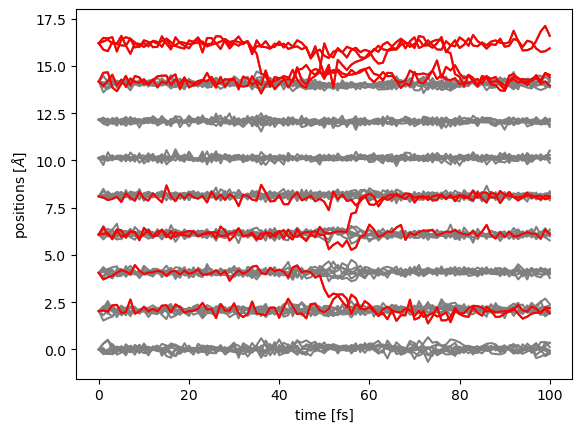

In [12]:
plt.plot(job_lammps.output.unwrapped_positions[:, :, 2], color="grey")
plt.plot(job_lammps.output.unwrapped_positions[:, H_indices, 2], color="red")
plt.xlabel("time [fs]")
plt.ylabel("positions [$\AA$]");

## Conclusion 
While the previous examples demonstrated the calculation of bulk properties, this example demonstrates the calculation of kinetic properties and more specifically defects in materials. 

## Exercises
* Calculate the diffusion in Nickel and compare it to the diffusion in Aluminium.
* How does the diffusion change with increasing with increasing temperature?
* How do other defects interact with the diffusion of Hydrogen? For example what is the effect of adding a vacancy? You can add a vacancy, by removing an atom using `del structure[-1]`.